In [1]:
import tensorflow as tf
import h5py 
import matplotlib.pyplot as plt
import numpy as np
import timeit
from sklearn import preprocessing

/anaconda3/envs/anacondapy2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# batched data generating function

In [2]:
def batch_generator(filename, batch_size):
    f = h5py.File(filename, 'r')
    batch_count = 0
    while True:
        if batch_count * batch_size + batch_size > f['label'].shape[0]: #若batchsize不能整除的話，最後餘下的資料永遠不會讀出
            batch_count = 0
        start_idx = batch_count * batch_size
        end_idx = start_idx + batch_size
        batch_count += 1
        yield f['data'][start_idx : end_idx] , f['label'][start_idx : end_idx]
    f.close()

# weight function

In [3]:
def w(shape): #weight
    return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='w')

def b(shape): #bias
    return tf.Variable(tf.constant(0.1,shape=shape), name='b')

def conv2d(x,w): #x:輸入影像，須為4維張量。 w:filter權重
    return tf.nn.conv2d(x, w, strides=[1,1,1,1], padding='SAME')

def maxpool2x2(x):
    return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')


# model

In [4]:
pr = 2
traindatafile_ =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq1024_pr'+str(pr)+'.h5'
modelstore = '/Volumes/Mac/GW/model/model-plain3_dropout.ckpt'

In [5]:
f = h5py.File(traindatafile_, 'r')
ll = len(f['data'])
print ll

6390


In [6]:
sample_rate = 8192
data_length = 8192 
T = data_length / sample_rate

nitv = 16.0
novl = 8.0
#f
lenf = int(sample_rate/nitv/2+1)
print 'lenth f =',lenf
#t
lent = int((nitv*T-1)*novl+1)
print 'lenth t =',lent
#total
totalpix = lenf*lent
print 'total',totalpix
#idx of f=1024
idx1024 = (lenf-1)/4
print 'idx1024=',idx1024


batchSize = 10
datasize = ll
totalBatchs = datasize/batchSize

c1fs = 7 #conv1 filter size
c1fn = 2 #conv1 filter number
c2fs = 5 #conv2 filter size
c2fn = 4 #conv2 filter number
c3fs = 3 #conv3 filter size
c3fn = 8 #conv3 filter number
dos1 = idx1024+1 #1st dim of spectrogram
dos2 = lent #2nd din of spectrogram
lnn1 = 128 #layer1 neuron number
lnn2 =32 #layer1 neuron number

lenth f = 257
lenth t = 121
total 31097
idx1024= 64


In [7]:
with tf.name_scope('input_layer'):
    x = tf.placeholder('float', shape=[None, dos1, dos2], name='x')
    x_image = tf.reshape(x, [-1, dos1, dos2, 1])
    
with tf.name_scope('c1_conv'):
    w1 = w([c1fs ,c1fs ,1, c1fn])
    b1 = b([c1fn])
    conv1 = conv2d(x_image, w1) + b1
    c1_conv = tf.nn.relu(conv1)
    
with tf.name_scope('c1_pool'):
    c1_pool = maxpool2x2(c1_conv)
    
with tf.name_scope('c2_conv'):
    w2 = w([c2fs ,c2fs , c1fn, c2fn])
    b2 = b([c2fn])
    conv2 = conv2d(c1_pool,w2) +b2
    c2_conv = tf.nn.relu(conv2)
    
    
with tf.name_scope('c3_conv'):
    w3 = w([c3fs ,c3fs ,c2fn, c3fn])
    b3 = b([c3fn])
    conv3 = conv2d(c2_conv, w3) + b3
    c3_conv = tf.nn.relu(conv3)
   
    
#neurons = dos1/8*dos2/8*c3fn
with tf.name_scope('D_flat'):
    D_Flat = tf.layers.Flatten()(c3_conv)

with tf.name_scope('D_hidden_layer1'):
    inputdim = D_Flat.shape.as_list()[1]
    wl1 = w([inputdim, lnn1])
    bl1 = b([lnn1])
    D_hidden1 = tf.nn.relu(tf.matmul(D_Flat, wl1)+bl1)
    D_hidden_dropout1 = tf.nn.dropout(D_hidden1, keep_prob=0.8)
    
with tf.name_scope('D_hidden_layer2'):
    wl2 = w([lnn1, lnn2])
    bl2 = b([lnn2])
    D_hidden2 = tf.nn.relu(tf.matmul(D_hidden_dropout1, wl2)+bl2)
    D_hidden_dropout2 = tf.nn.dropout(D_hidden2, keep_prob=0.8)
    
with tf.name_scope('output_layer'):
    wo = w([lnn2,2])
    bo = b([2])
    #y_predict = tf.sigmoid(tf.matmul(D_hidden_dropout2,wo)+bo)
    y_predict = tf.nn.softmax(tf.matmul(D_hidden_dropout2,wo)+bo)    

    
with tf.name_scope('optimizer'):
    y_label = tf.placeholder('float', shape=[None,2], name='y_label')
    #lossfunction = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    lossfunction = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=y_predict, labels=y_label))
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(lossfunction)
    
with tf.name_scope('evaluate_model'):
    correct_prediction = tf.equal(tf.argmax(y_predict,1), tf.argmax(y_label,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction,'float'))

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



# evaluate

In [20]:
def evaluate(trainEpochs,peakratio):

    start_time = timeit.default_timer()
    sess = tf.Session()

    saver = tf.train.Saver()

    try: #第一次之後執行
        saver.restore(sess, modelstore)
    except: #第一次跑時執行
        sess.run(tf.global_variables_initializer())

    traindatafile =  '/Volumes/Mac/GW/spec/withoutoverlap/5~75/trainingdatawo_spec16-8_freq1024_pr'+str(peakratio)+'.h5'
    valdatafile = '/Volumes/Mac/GW/spec/overlap/5~75/validationdata_spec16-8_freq1024_pr'+str(peakratio)+'.h5'
    
    
    bg = batch_generator(traindatafile, batchSize)
    fval = h5py.File(valdatafile, 'r')
    val_x = fval['data'][...]
    val_y = fval['label'][...]
    #np_utils.to_categorical
    for epoch in range(trainEpochs):
        for i in range(totalBatchs):
            #每次讀取100筆資料
            batch_x, batch_y = next(bg)
            #將feature和label輸入並計算執行圖
            sess.run(optimizer, feed_dict={x : batch_x, y_label : sess.run(tf.one_hot(batch_y, 2)) })
        #使用驗證資料計算一次epoch的loss和acc    
        loss, acc = sess.run([lossfunction,accuracy],feed_dict={x : val_x, y_label : sess.run(tf.one_hot(val_y, 2))})
    
        print 'Train Epoch:', '%02d'%(epoch+1), 'Loss=', '{:.9f}'.format(loss), 'Accuracy=',acc
    

    saver.save(sess, modelstore)

    fval.close()
    stop_time = timeit.default_timer()
    print 'period(s) =', stop_time - start_time
    
    
def estimate(testdatafile):
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    print 'acc :', sess.run(accuracy, feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2)) })
    stop_time = timeit.default_timer()
    print 'period of estimate =', stop_time - start_time, '(s)'
    
def prediction_result(testdatafile):
    ftest = h5py.File(testdatafile, 'r')
    test_x = ftest['data'][...]
    test_y = ftest['label'][...]
    ftest.close()
    
    start_time = timeit.default_timer()
    predictresult = sess.run(tf.argmax(y_predict, 1), feed_dict={x : test_x, y_label : sess.run(tf.one_hot(test_y, 2))})
    stop_time = timeit.default_timer()
    print 'period of prediction =', stop_time - start_time, '(s)'
    return predictresult

In [21]:
def relation(n):
    sess = tf.Session()
    saver = tf.train.Saver()
    saver.restore(sess, modelstore)
    d = '/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5_2time10_'
    rm = np.zeros([70,70])
    cm = np.zeros([2,2])
    for j in range(n):
        data =  d+str(j)+'.h5'
        test = h5py.File(data, 'r')
        test_par = test['parameter'][...]
        test_lab = test['label'][...]
        test.close()
        predict = prediction_result(data)
        cm += confusionmatrix(predict,test_lab)
        for i in range(len(test_par)):
            if test_par[i,0] != 0: #選擇有訊號的數據
                if test_lab[i] != predict[i]: #預測不正確則顏色加深
                    row = int(test_par[i,0]-5.5)
                    col =  int(test_par[i,1]-5.5)
                    rm[row,col] += 1.
    acc(cm)
    sensitivity(cm)
    false_alarm_rate(cm)
    scale = preprocessing.MinMaxScaler(feature_range=(0,1))
    rmr = rm.reshape(70*70,1)
    rmrn = scale.fit_transform(rmr)
    rm = rmrn.reshape(70, 70)
    
    plt.imshow(rm, cmap='binary')
    tick_idx = [0,10,20,30,40,50,60]
    tick_mass = [5.5,15.5,25.5,35.5,45.5,55.5,65.5]
    plt.yticks(tick_idx , tick_mass)
    plt.xticks(tick_idx , tick_mass)

def confusionmatrix(prediction_result,test_y):
    sess = tf.Session()
    cm = sess.run(tf.confusion_matrix(test_y, prediction_result))
    print 'confusionmatrix ='
    print cm
    return cm

def false_alarm_rate(cm):
    fp = cm[0,1].astype('float64')
    tn = cm[0,0].astype('float64')
    print 'false alarm rate =',fp/(fp+tn) #false alarm rate

def sensitivity(cm):
    tp = cm[1,1].astype('float64')
    fn = cm[1,0].astype('float64')
    print 'sensitivity =',tp/(tp+fn) #sensitivity
    

def acc(cm):
    print 'acc =',(cm[0,0]+cm[1,1])/np.sum(cm)
def summary():
    estimate()
    pr = prediction_result()
    cm = confusionmatrix(pr)
    false_alarm_rate(cm)
    sensitivity(cm)

In [15]:
evaluate(2,2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.314312220 Accuracy= 1.0
Train Epoch: 02 Loss= 0.313498795 Accuracy= 1.0
period(s) = 416.807619095


In [16]:
evaluate(2,1.5) 

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.313812733 Accuracy= 0.9996667
Train Epoch: 02 Loss= 0.313372761 Accuracy= 1.0
period(s) = 616.155874968


In [17]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.319516122 Accuracy= 0.99366665
Train Epoch: 02 Loss= 0.317050010 Accuracy= 0.99666667
Train Epoch: 03 Loss= 0.319155186 Accuracy= 0.99366665
Train Epoch: 04 Loss= 0.315227896 Accuracy= 0.998
period(s) = 1979.01717997


In [9]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.319023430 Accuracy= 0.99633336
Train Epoch: 02 Loss= 0.315912604 Accuracy= 0.99866664
Train Epoch: 03 Loss= 0.319232374 Accuracy= 0.9943333
Train Epoch: 04 Loss= 0.316910565 Accuracy= 0.997
period(s) = 813.945278883


In [9]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.316579133 Accuracy= 0.99733335
Train Epoch: 02 Loss= 0.317305058 Accuracy= 0.996
Train Epoch: 03 Loss= 0.315341949 Accuracy= 0.998
Train Epoch: 04 Loss= 0.315615833 Accuracy= 0.998
period(s) = 764.41482091


In [9]:
evaluate(4,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.315589666 Accuracy= 0.998
Train Epoch: 02 Loss= 0.315450221 Accuracy= 0.998
Train Epoch: 03 Loss= 0.316531539 Accuracy= 0.99666667
Train Epoch: 04 Loss= 0.316641659 Accuracy= 0.99633336
period(s) = 774.783993959


In [9]:
evaluate(8,1.2)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.314720482 Accuracy= 0.99866664
Train Epoch: 02 Loss= 0.313822031 Accuracy= 0.9993333
Train Epoch: 03 Loss= 0.321663350 Accuracy= 0.9906667
Train Epoch: 04 Loss= 0.314037293 Accuracy= 0.999
Train Epoch: 05 Loss= 0.321323007 Accuracy= 0.99233335
Train Epoch: 06 Loss= 0.314517230 Accuracy= 0.999
Train Epoch: 07 Loss= 0.314433753 Accuracy= 0.99866664
Train Epoch: 08 Loss= 0.333722025 Accuracy= 0.978
period(s) = 2382.66357517


In [9]:
evaluate(8,1)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.322500765 Accuracy= 0.9906667
Train Epoch: 02 Loss= 0.320623010 Accuracy= 0.99233335
Train Epoch: 03 Loss= 0.320791095 Accuracy= 0.99233335
Train Epoch: 04 Loss= 0.317328870 Accuracy= 0.9956667
Train Epoch: 05 Loss= 0.317367971 Accuracy= 0.9956667
Train Epoch: 06 Loss= 0.323222339 Accuracy= 0.991
Train Epoch: 07 Loss= 0.320161164 Accuracy= 0.99233335
Train Epoch: 08 Loss= 0.320749193 Accuracy= 0.9913333
period(s) = 2335.84309506


In [9]:
evaluate(8,0.8)
evaluate(8,0.7)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.331047595 Accuracy= 0.98333335
Train Epoch: 02 Loss= 0.333285630 Accuracy= 0.9816667
Train Epoch: 03 Loss= 0.330422878 Accuracy= 0.98233336
Train Epoch: 04 Loss= 0.328457534 Accuracy= 0.9853333
Train Epoch: 05 Loss= 0.337383837 Accuracy= 0.97566664
Train Epoch: 06 Loss= 0.333850682 Accuracy= 0.97966665
Train Epoch: 07 Loss= 0.343059003 Accuracy= 0.968
Train Epoch: 08 Loss= 0.333681554 Accuracy= 0.97866666
period(s) = 2616.03786898
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.344401568 Accuracy= 0.9686667
Train Epoch: 02 Loss= 0.338697523 Accuracy= 0.975
Train Epoch: 03 Loss= 0.338517010 Accuracy= 0.97366667
Train Epoch: 04 Loss= 0.336756706 Accuracy= 0.97566664
Train Epoch: 05 Loss= 0.336402148 Accuracy= 0.97533333
Train Epoch: 06 Loss= 0.334631383 Accuracy= 0.97866666
Train Epoch: 07 Loss= 0.334342569 Acc

KeyboardInterrupt: 

In [9]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.369114310 Accuracy= 0.941
Train Epoch: 02 Loss= 0.370726645 Accuracy= 0.939
Train Epoch: 03 Loss= 0.363864183 Accuracy= 0.946
Train Epoch: 04 Loss= 0.363442451 Accuracy= 0.948
period(s) = 782.651520967


In [9]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.360735834 Accuracy= 0.949
Train Epoch: 02 Loss= 0.361507893 Accuracy= 0.95
Train Epoch: 03 Loss= 0.367463589 Accuracy= 0.943
Train Epoch: 04 Loss= 0.369776607 Accuracy= 0.94266665
period(s) = 769.546099901


In [9]:
evaluate(4,0.6)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.371246099 Accuracy= 0.9406667
Train Epoch: 02 Loss= 0.363519847 Accuracy= 0.9486667
Train Epoch: 03 Loss= 0.363523930 Accuracy= 0.9483333
Train Epoch: 04 Loss= 0.366521925 Accuracy= 0.945
period(s) = 738.891927004


In [9]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.421951085 Accuracy= 0.886
Train Epoch: 02 Loss= 0.417751968 Accuracy= 0.892
Train Epoch: 03 Loss= 0.416237712 Accuracy= 0.89433336
Train Epoch: 04 Loss= 0.414444506 Accuracy= 0.8946667
period(s) = 795.118284941


In [10]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.416779786 Accuracy= 0.8933333
Train Epoch: 02 Loss= 0.415950358 Accuracy= 0.893
Train Epoch: 03 Loss= 0.418388844 Accuracy= 0.89066666
Train Epoch: 04 Loss= 0.417938083 Accuracy= 0.89066666
period(s) = 1782.31662607


In [9]:
evaluate(4,0.5)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
Train Epoch: 01 Loss= 0.416604251 Accuracy= 0.893
Train Epoch: 02 Loss= 0.420340180 Accuracy= 0.8883333
Train Epoch: 03 Loss= 0.417833388 Accuracy= 0.89266664
Train Epoch: 04 Loss= 0.423452705 Accuracy= 0.8886667
period(s) = 760.040786028


In [23]:
estimate('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5.h5')

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
acc : 0.8934321
period of estimate = 36.4916870594 (s)


In [26]:
test = h5py.File('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5.h5', 'r')
test_label = test['label'][...]
test.close()
cc=confusionmatrix(prediction_result('/Volumes/Mac/GW/spec/withoutoverlap/5.5~74.5/testdatawo_spec16-8_freq1024_pr0.5.h5'),
               test_label)

INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 37.6389350891 (s)
confusionmatrix =
[[3538  189]
 [ 479 2006]]


In [27]:
false_alarm_rate(cc)
sensitivity(cc)

false alarm rate = 0.0507110276361685
sensitivity = 0.8072434607645875


INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 33.6440458298 (s)
confusionmatrix =
[[ 524   28]
 [ 914 4056]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 30.2359628677 (s)
confusionmatrix =
[[ 523   29]
 [ 881 4089]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 30.0708429813 (s)
confusionmatrix =
[[ 523   29]
 [ 953 4017]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.6230120659 (s)
confusionmatrix =
[[ 523   29]
 [ 864 4106]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.5077691078 (s)
confusionmatrix =
[[ 525   27]
 [ 906 4064]]
INFO:tensorflow:Restoring para

period of prediction = 29.883756876 (s)
confusionmatrix =
[[ 523   29]
 [ 914 4056]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.5388150215 (s)
confusionmatrix =
[[ 522   30]
 [ 922 4048]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.4869558811 (s)
confusionmatrix =
[[ 524   28]
 [ 962 4008]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.2653019428 (s)
confusionmatrix =
[[ 525   27]
 [ 926 4044]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 31.2446501255 (s)
confusionmatrix =
[[ 523   29]
 [ 923 4047]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.8379569054 (s)
confusionmatrix =
[[ 525   27]
 [ 930 4040]]
INFO:tensorflow:Restoring parameter

period of prediction = 30.1174609661 (s)
confusionmatrix =
[[ 526   26]
 [ 874 4096]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 30.1750450134 (s)
confusionmatrix =
[[ 527   25]
 [ 890 4080]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.7324020863 (s)
confusionmatrix =
[[ 517   35]
 [ 914 4056]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 30.0809860229 (s)
confusionmatrix =
[[ 535   17]
 [ 895 4075]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.7571909428 (s)
confusionmatrix =
[[ 522   30]
 [ 896 4074]]
INFO:tensorflow:Restoring parameters from /Volumes/Mac/GW/model/model-plain3_dropout.ckpt
period of prediction = 29.6673710346 (s)
confusionmatrix =
[[ 528   24]
 [ 921 4049]]
INFO:tensorflow:Restoring paramete

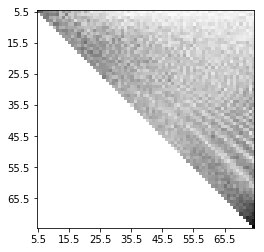

In [22]:
relation(100)